# Biomedicina: Entrenamiento y clasificacion de datos EEG

In [1]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import radviz
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 12

## Preprocesado de datos

In [3]:
s1 = '/home/cramos/Dropbox/BIO/train_subject1_raw01.asc'
s2 = '/home/cramos/Dropbox/BIO/train_subject1_raw02.asc'
s3 = '/home/cramos/Dropbox/BIO/train_subject1_raw03.asc'
t = '/home/cramos/Dropbox/BIO/test_subject1_raw04.asc'
yr = '/home/cramos/Dropbox/BIO/res_subject1_raw.asc'
sub1 = pd.read_fwf(s1, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])
sub2 = pd.read_fwf(s2, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])
sub3 = pd.read_fwf(s3, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])
tst = pd.read_fwf(t, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])
y_r = pd.read_fwf(yr)

Tomamos los 3 datasets de entrenamiento y los conatenamos en un solo dataframe (subs).

In [4]:
frames = [sub1, sub2, sub3]
subs = pd.concat(frames)

In [5]:
subs

,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,...,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz,Clase
0,2376.6362,-3993.0707,-292.01509,-1714.575000,-8560.3748,-12959.398,-15365.081,6104.5356,3067.4475,4910.1941,...,-7562.5642,-4529.94480,-3280.6658,-3277.9158,2412.3237,-2788.79170,5308.7558,7220.2523,11014.589,7
1,2385.5737,-3979.3833,-284.70260,-1706.606200,-8550.4998,-12953.335,-15362.925,6113.7543,3079.7912,4918.8190,...,-7562.2517,-4517.10100,-3269.2596,-3267.8221,2422.1049,-2779.47920,5306.6933,7232.2835,11026.745,7
2,2406.0424,-3954.7583,-266.32763,-1687.262500,-8529.3749,-12933.273,-15331.175,6134.6605,3101.6036,4940.0377,...,-7520.0642,-4502.25730,-3249.6971,-3246.3534,2438.0736,-2760.76050,5318.4433,7253.6585,11048.589,7
3,2435.9486,-3925.4459,-235.79644,-1659.481300,-8503.3749,-12903.054,-15292.987,6160.7542,3124.7911,4966.7252,...,-7495.2518,-4472.78860,-3224.3534,-3218.3534,2468.1986,-2730.51060,5343.7245,7280.4397,11071.714,7
4,2454.2298,-3911.9146,-219.73397,-1644.075100,-8492.0937,-12885.867,-15274.956,6173.8480,3133.7286,4979.9439,...,-7489.4080,-4458.85110,-3214.2284,-3206.5722,2480.1360,-2713.44810,5355.5370,7291.0647,11081.370,7
5,2471.3861,-3900.6959,-205.79650,-1632.075100,-8482.1875,-12873.961,-15263.175,6185.5667,3142.5723,4993.5064,...,-7473.1893,-4445.66370,-3206.2285,-3195.4472,2491.8235,-2700.54190,5367.8495,7300.7521,11089.745,7
6,2456.5736,-3913.5709,-219.35897,-1643.825100,-8494.6562,-12883.617,-15279.019,6174.9417,3131.0411,4982.7252,...,-7477.0331,-4459.41360,-3219.9472,-3208.2597,2480.9798,-2712.35440,5356.3807,7287.8772,11076.151,7
7,2430.3236,-3932.3209,-239.98393,-1661.325100,-8512.4374,-12903.429,-15297.581,6156.7230,3113.1036,4965.1002,...,-7494.5330,-4478.91360,-3237.8221,-3227.9472,2460.8861,-2733.79180,5335.0370,7269.5334,11059.151,7
8,2401.7924,-3954.7583,-265.14014,-1683.231300,-8534.3436,-12931.023,-15323.894,6132.4418,3090.4162,4938.7565,...,-7520.5330,-4501.31980,-3257.6659,-3247.0409,2438.0736,-2760.94800,5313.3183,7247.3147,11039.401,7
9,2387.1987,-3969.7583,-279.98386,-1698.481200,-8546.9373,-12945.679,-15342.706,6116.2543,3076.6974,4919.1628,...,-7536.0330,-4514.97600,-3266.9783,-3258.1659,2426.8861,-2776.13550,5301.5058,7234.6585,11029.089,7


In [6]:
subs.shape

(366592, 33)

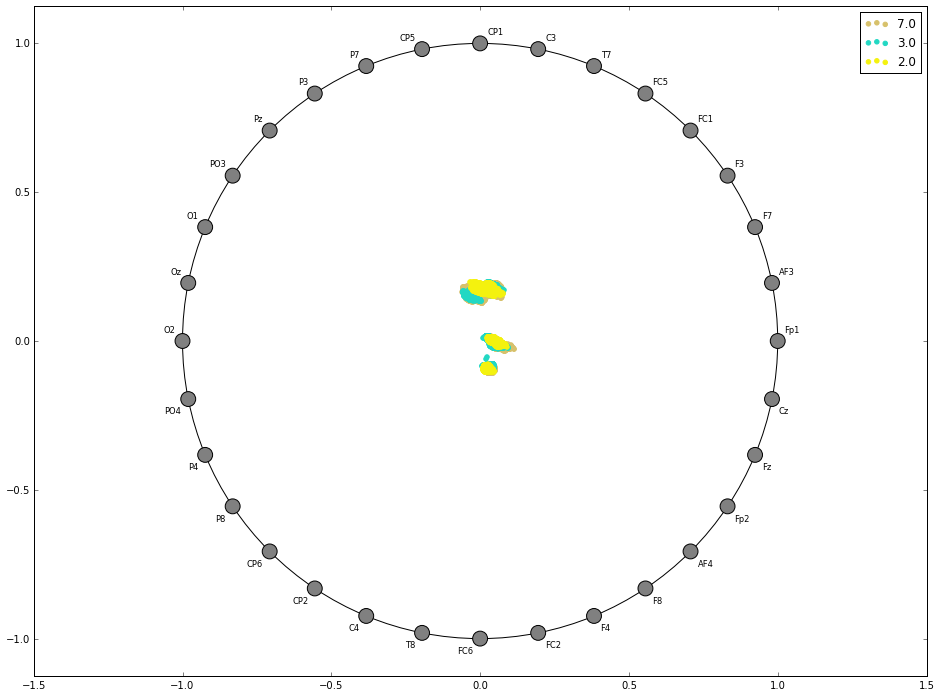

In [7]:
radviz(subs, 'Clase')

Como podemos observar, las clases se encuentran muy acopladas entre sí. Vamos a plotear un scatter de la relación entre P3, FC1 y Fp2 para las tres clases:

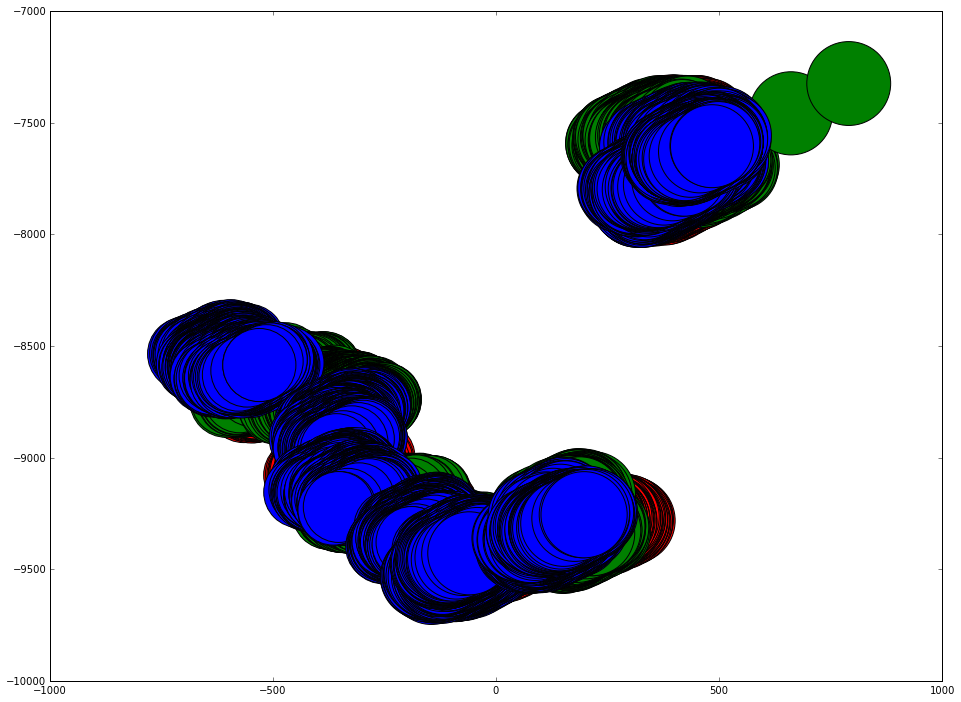

In [8]:
plt.scatter(subs[subs.Clase == 2].P3, subs[subs.Clase == 2].FC1, subs[subs.Clase == 2].Fp2, 'r')
plt.hold
plt.scatter(subs[subs.Clase == 3].P3, subs[subs.Clase == 3].FC1, subs[subs.Clase == 3].Fp2, 'g')
plt.scatter(subs[subs.Clase == 7].P3, subs[subs.Clase == 7].FC1, subs[subs.Clase == 7].Fp2, 'b')

### Construcción de matrices de entrenamiento

In [9]:
X = subs.iloc[:,0:32].values
y = subs.iloc[:,32:].values

In [10]:
Xt = tst.iloc[:,0:32].values
y_real = np.matrix(y_r)

In [11]:
X.shape, y.shape, Xt.shape

((366592, 32), (366592, 1), (120832, 32))

In [12]:
y = np.ravel(y)

###  Reducción de características

In [13]:
selection = SelectKBest(k=30)
X_red = selection.fit(X, y).transform(X)

In [14]:
col_sel = []
for i in X_red[0,:]:
    for j in np.linspace(1, np.size(X[0,:]), np.size(X[0,:])):
        if X[0,:][j-1] == i:
            col_sel.append(j-1)
col_sel

/home/cramos/.local/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0]

In [15]:
X[:,col_sel] == X_red

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

## Entrenamiento

Obtenemos el número de n_neighbors óptimo para el algoritmo KNN. Para ello, primeramente recortamos la matriz de testeo (el vector de resultados reales es sólo de 470x1). Seguidamente, se comprueba mediante score la precisión del algoritmo en función de n_neighbours. Posteriormente plotearemos el vector obtenido, para conocer n_neighbours óptimo sin llegar a overfitting.

In [16]:
Xtt = Xt[1:471][:]

In [17]:
results = []
for n in range(1, 301, 20):
    clf = KNeighborsClassifier(n_neighbors=n).fit(X_red,y)
    results.append([n,clf.score(Xtt[:,col_sel],y_real)])

In [18]:
results = np.array(results)

In [19]:
results

array([[   1.        ,    0.36382979],
       [  21.        ,    0.29574468],
       [  41.        ,    0.29787234],
       [  61.        ,    0.30212766],
       [  81.        ,    0.29574468],
       [ 101.        ,    0.2893617 ],
       [ 121.        ,    0.29361702],
       [ 141.        ,    0.29148936],
       [ 161.        ,    0.2893617 ],
       [ 181.        ,    0.2893617 ],
       [ 201.        ,    0.2893617 ],
       [ 221.        ,    0.29148936],
       [ 241.        ,    0.29148936],
       [ 261.        ,    0.29148936],
       [ 281.        ,    0.29361702]])

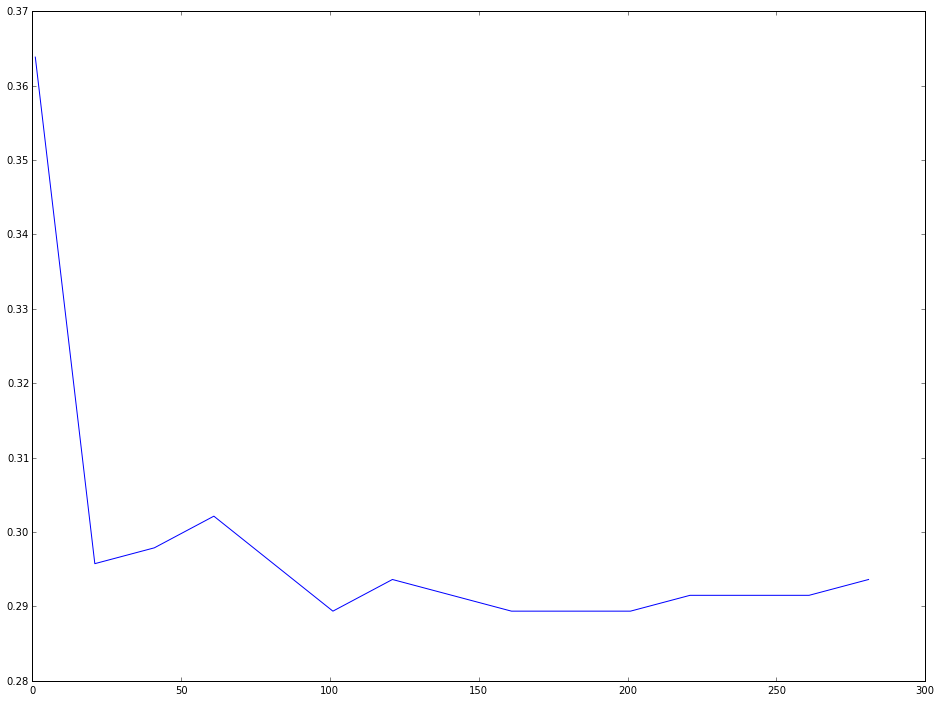

In [20]:
plt.plot(results[:,0], results[:,1])

In [21]:
cla = KNeighborsClassifier(n_neighbors = 1)

In [22]:
cla_apr = cla.fit(X_red, y)

## Clasificación

In [23]:
Yt = cla_apr.predict(Xt[:,col_sel])

Después de predecir volvemos a construir el dataframe con los resultados:

In [24]:
Yt=np.matrix(Yt)

In [25]:
subt = np.concatenate((Xt,Yt.T), axis=1)

In [26]:
subt = pd.DataFrame(subt, columns=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])

In [27]:
subt

,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,...,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz,Clase
0,6509.2848,-5059.1313,-899.45146,81.546723,-7476.4393,-11360.557,-11520.619,4209.3203,5907.2547,2685.3232,...,-9804.9350,430.95233,-2085.1993,1595.3877,1902.6059,1127.5448,6634.4096,6571.5660,12027.243,3
1,6514.4411,-5053.9438,-891.92023,88.202961,-7466.3456,-11353.588,-11514.026,4218.6953,5919.3484,2694.6981,...,-9798.7788,439.10856,-2073.5118,1604.4502,1913.4183,1134.7948,6640.8159,6579.7535,12038.525,3
2,6525.5036,-5043.1626,-882.26400,100.765440,-7452.1269,-11341.026,-11500.776,4232.9766,5933.5984,2708.2919,...,-9785.4350,453.13979,-2058.5431,1618.0126,1925.7933,1147.4510,6652.3158,6593.9097,12053.931,3
3,6545.0973,-5021.8188,-862.23278,122.202900,-7431.5644,-11321.120,-11479.182,4254.5703,5954.6609,2729.4168,...,-9764.9038,475.26475,-2038.4494,1640.7938,1947.1683,1169.7635,6672.5345,6614.6909,12073.993,2
4,6558.6285,-5006.9439,-847.95156,137.015370,-7417.7519,-11309.557,-11467.838,4268.3515,5967.0983,2743.1981,...,-9752.1851,490.26472,-2025.4806,1657.4813,1962.2620,1184.2947,6688.5658,6629.0659,12085.931,2
5,6562.4722,-5000.8189,-840.67032,140.984110,-7416.6582,-11301.463,-11464.026,4271.7265,5967.1608,2748.5105,...,-9747.8101,494.92096,-2025.8869,1661.6063,1967.5120,1188.2322,6692.5033,6631.4096,12085.900,2
6,6548.1285,-5013.1001,-856.26404,128.671640,-7431.2519,-11312.182,-11474.307,4259.6015,5954.4109,2738.8543,...,-9759.9976,478.48349,-2040.6369,1647.3563,1956.0745,1176.1697,6678.8783,6617.8159,12071.212,2
7,6526.8161,-5030.9751,-879.76400,108.640420,-7452.2519,-11333.401,-11495.307,4239.6015,5933.6297,2720.1668,...,-9780.1851,457.26478,-2060.5118,1627.5751,1937.2308,1155.3260,6657.0033,6597.0659,12050.681,3
8,6509.0348,-5052.9438,-899.76396,88.827960,-7471.8143,-11352.963,-11517.463,4219.4766,5915.0672,2698.5731,...,-9799.3100,441.67106,-2075.8243,1610.3564,1922.4808,1137.0760,6638.4096,6578.0035,12033.087,3
9,6498.8474,-5065.9750,-910.01394,78.296729,-7476.8143,-11362.682,-11533.526,4210.6953,5909.8797,2687.6044,...,-9808.7163,428.70233,-2080.6368,1600.2939,1899.5746,1127.5135,6630.9721,6571.3160,12028.556,3


## Ploteo de resultados

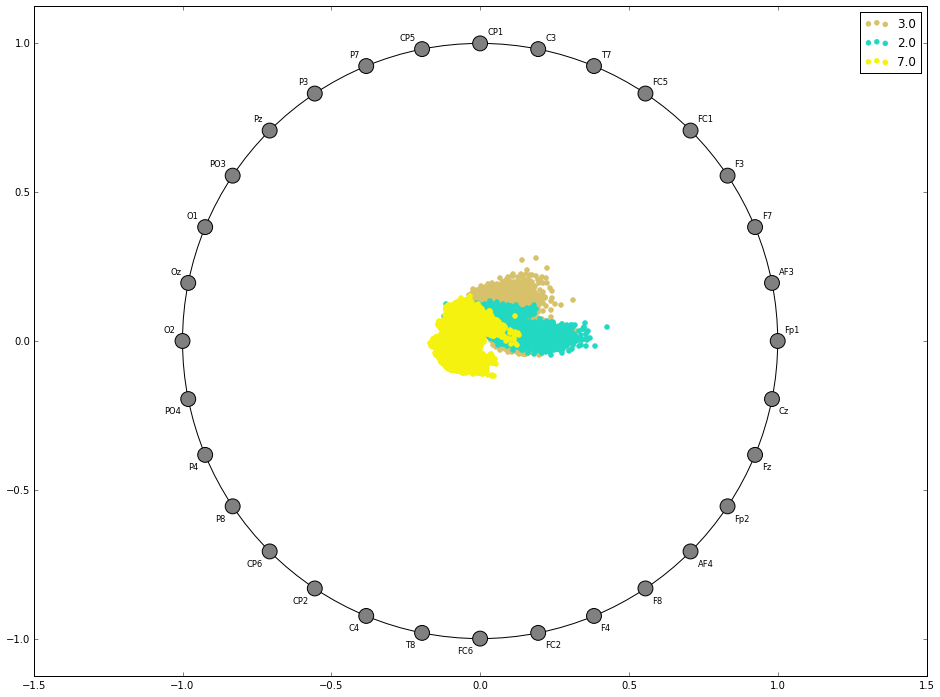

In [28]:
radviz(subt, 'Clase')

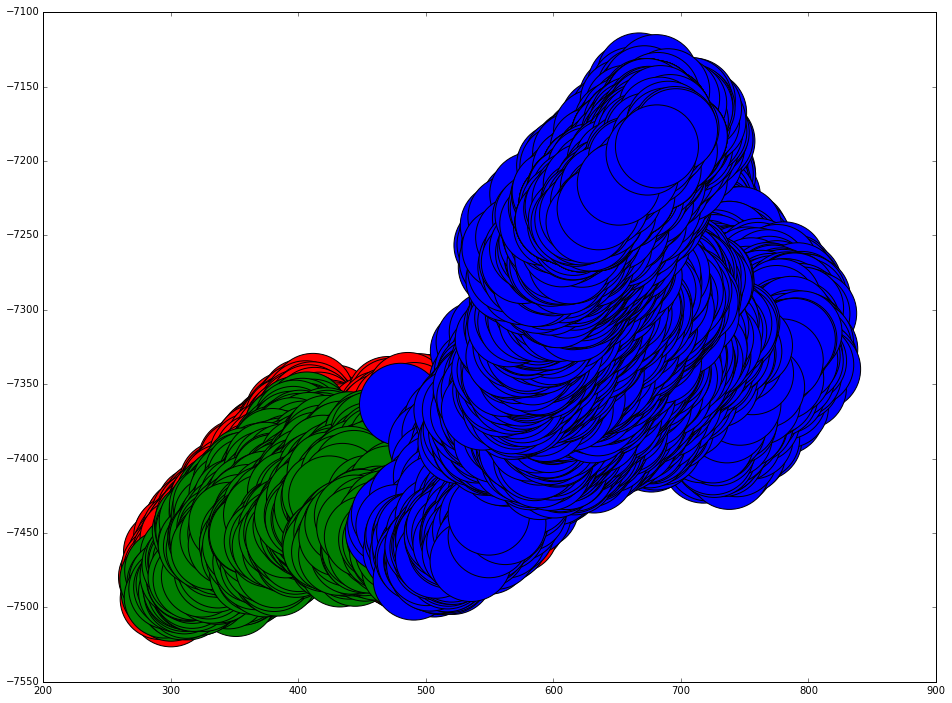

In [29]:
plt.scatter(subt[subt.Clase == 2].P3, subt[subt.Clase == 2].FC1, subt[subt.Clase == 2].Fp2, 'r')
plt.hold
plt.scatter(subt[subt.Clase == 3].P3, subt[subt.Clase == 3].FC1, subt[subt.Clase == 3].Fp2, 'g')
plt.scatter(subt[subt.Clase == 7].P3, subt[subt.Clase == 7].FC1, subt[subt.Clase == 7].Fp2, 'b')